This cell sets some notebook parameters.

In [18]:
#cells will fill entire width of the browser
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

#Tells Jupyter to reload custom classes from scratch everytime an import cell is run, if you edit a custom class
#between imports Jupyter would otherwise need to be restarted completely. Buyer beware: old class objects in the 
#current namespace will cause errors at execution
%load_ext autoreload
%autoreload 2

#switches matplotlib to show plots in the browser rather than opening a new window
%matplotlib inline

#always forget to do this for better looking plots
#import seaborn
#seaborn.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing libraries

In [19]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

#passive library that generates nicer looking plots
import seaborn
seaborn.set()

### Function Definitions

In [89]:
def pandas_parse_fzp_vissim_vehicle_records(filename):
    #this function parses a vehicle records fzp file and 
    #reads the data into a pandas dataframe
    
    #FZP file notes
    #lines beginning with * are comments
    #escape character \ is not an escape character (VISSIM sucks)
    #line beginning with $ is header
    #data is ; delimited
    #dataframe will come back with all strings as data

    data = []
    
    with open(filename, 'r') as d:
        for line in d:
            if line[0] == "*":
                pass
            elif line[0:8] == "$VEHICLE": #column header doesn't precisely correspond to columns
                header = line.replace("\\","_").strip().split(";") #VISSIM uses stupid escape characters in stupid places
                header[0] = header[0].split(":")[1] #getting rid of garbage at start of column header
            elif line[0] == "$":
                pass
            else:       
                data.append(line.strip().split(";"))
                
    out_frame = pd.DataFrame(data)
    out_frame = out_frame.drop(labels=0, axis=0) #ends up reading first line anyway because of garbage unicode
    out_frame.columns = header
    
    return(out_frame)

### Reading an FZP file

In [111]:
datapath = "C:\\Users\\chase\\Documents\\vissimpark\\VISSIM_configs\\VISSIM August\\Scenario 1" #path to the location of the FZP file you want to read
filename = "SLU-fnl-baseline_001.fzp" #FZP file you want to read

vehicle_records = pandas_parse_fzp_vissim_vehicle_records(os.path.join(datapath, filename)) #os.path.join is ambigious to operating system so put whatever path definition into datapath you need

### Plot parking times

In [114]:
#first we'll find out the maximum vehicle index number 'NO'
max_vehicle = max(np.array(vehicle_records['NO'].values, dtype=np.int64))

#store dwell times by vehicle type: key is vehicle type number, value is a list of a dwell times
parked_times_by_type = {}

for i in range(max_vehicle+1):
    data = vehicle_records.loc[(vehicle_records['NO'] == str(i)) & (vehicle_records['PARKSTATE'] == 'Parked')] #here we create a temporary dataframe 
    try:
        #park_time = float(data.iloc[-1]['SIMSEC']) - float(data.iloc[0]['SIMSEC'])
        park_time = float(data.iloc[0]['DWELLTM']) #first value that appears in table seems to be total dwell time and counts down with each subsequent record value for that vehicle
        vtype = data.iloc[0]['VEHTYPE'] #grab the vehicle type
        if vtype not in parked_times_by_type:
            parked_times_by_type[vtype] = [park_time]
        else:
            parked_times_by_type[vtype].append(park_time)
    except:
        pass

Text(0.5, 1.0, 'Distribution of parking times in sim seconds')

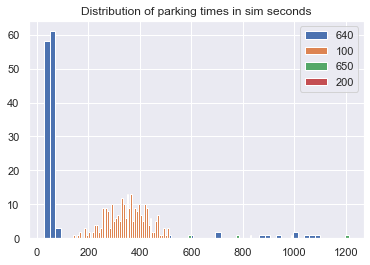

In [117]:
#plot the histogram of dwell times by vehicle type

for i in parked_times_by_type:
    plt.hist(parked_times_by_type[i], label=i, bins=50)
plt.legend()    
plt.title("Distribution of parking times in sim seconds")

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

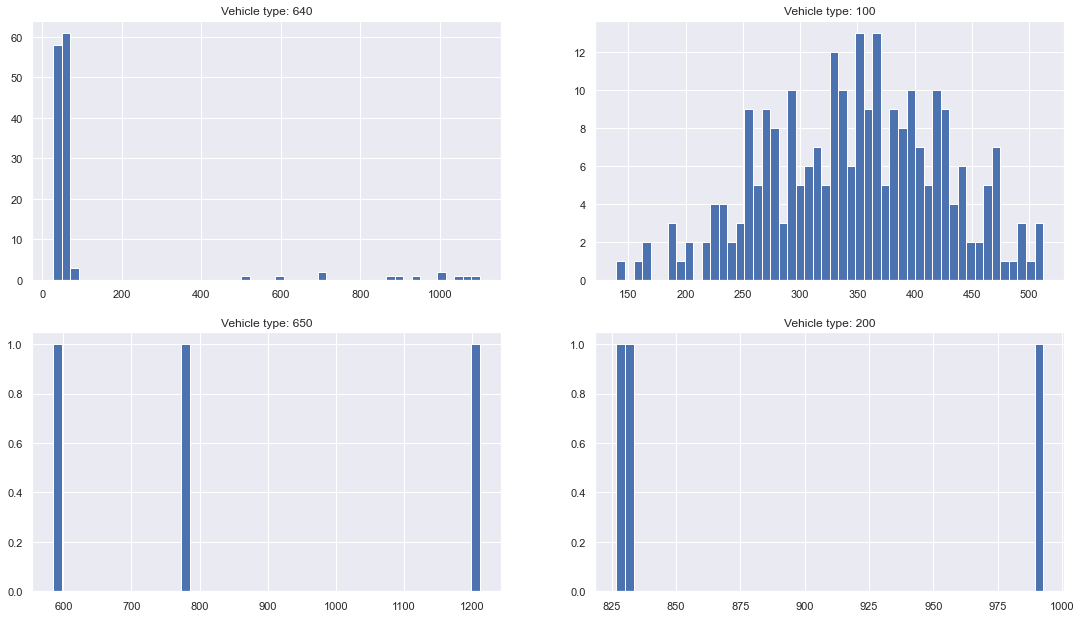

In [124]:
#plot each vehicle type individually
veh_types = list(parked_times_by_type.keys())

fig, axs = plt.subplots(2, 2)

for i, vtype in enumerate(veh_types):
    axs.flatten()[i].hist(parked_times_by_type[vtype], bins=50)
    axs.flatten()[i].set_title("Vehicle type: " + str(vtype))
    ax.set(xlabel='Dwell Time', ylabel='# of occurences')

fig.set_size_inches(18.5, 10.5)


### Occupancy measurement by space

In [92]:
#read parking_lot_allocations into memory

datapath = "C:\\Users\\chase\\Documents\\vissimpark\\data" #path to the location of the allocation file you want to read
filename = "parking_lot_allocations.xlsx"

with open(os.path.join(datapath, filename), 'rb') as d:
    parking_lot_allocations = pd.read_excel(d)

Vehicle records are measured by event and then discretized by some fixed measurement window we need to instantiate a series of fixed time bins and fill in whether or not a space is occupied given asynchronous measurements in the vehicle records

In [96]:
#get the maximum simulation time
simtime = max([ float(i) for i in vehicle_records['SIMSEC'].values ]) 

#The list comprehension above is because I have to force every value in the array 
#to be a float since pandas reads fzp file data as all strings

#instantiate a park/no-park indicator for each parking space

parking_indicator = {}
for index, row in parking_lot_allocations.iterrows():
    parking_indicator[row["DESTPARKLOT"]] = []
    for i in range(0,int(simtime),1): #compute floor of integer simulation time (i.e. 4.9 = 4), iterate by 1
        parking_indicator[row["DESTPARKLOT"]].append(0)
        
#now fill in the parking_indicator with vehicle records data
for dest_space in parking_indicator:
    print("Reading parking space: " + str(dest_space))
    
    #we need to keep track of unique arrivals to this parking space
    parking_records_tracker = []

    #get all vehicle records this particular space when "PARKED" event is active and not "en route" or anything
    data = vehicle_records.loc[(vehicle_records['DESTPARKLOT'] == str(dest_space)) & (vehicle_records['PARKSTATE'] == 'Parked')]
    if len(data) > 0: #records are returned
        for index, row in data.iterrows():
            parking_tracker_key = str(row['NO']) + str(dest_space)
            if parking_tracker_key not in parking_records_tracker:
                #this is a new parking event
                parking_records_tracker.append(parking_tracker_key)
                curr_time = int(float(row['SIMSEC']))
                park_time = int(float(row['DWELLTM'])) #this may exceed horizon of simulation
                time_counter = 0
                while time_counter < park_time:
                    if curr_time + time_counter > len(parking_indicator[int(row["DESTPARKLOT"])]) - 1:
                        break
                    else:
                        parking_indicator[int(row["DESTPARKLOT"])][curr_time + time_counter] = 1
                        time_counter += 1
            else:
                pass
    else:
        pass

Reading parking space: 16
Reading parking space: 17
Reading parking space: 18
Reading parking space: 20
Reading parking space: 24
Reading parking space: 36
Reading parking space: 37
Reading parking space: 39
Reading parking space: 41
Reading parking space: 42
Reading parking space: 43
Reading parking space: 44


In [110]:
print("Space \t | \t Occupancy")
print("---------------------------------")
for space in parking_indicator:
    print(str(space) + "\t | \t" + str(np.mean(parking_indicator[space])*100.0))

Space 	 | 	 Occupancy
---------------------------------
16	 | 	0.0
17	 | 	40.01296416334846
18	 | 	87.13769793499398
20	 | 	93.1475136586721
24	 | 	86.67469210112047
36	 | 	84.58190573201222
37	 | 	81.72978979535142
39	 | 	65.87647004352254
41	 | 	85.8598018335031
42	 | 	17.307158070191683
43	 | 	69.17307158070192
44	 | 	48.37484952310399


### Parking success rate

In [105]:
#divide the number of "declined" by the total number of "parked" and "declined"
success_by_space = {}

for index, row in parking_lot_allocations.iterrows():
    dest_space = row["DESTPARKLOT"]
    success_by_space[dest_space] = []
    
    #keep track of accepted and declined parking
    declines = set() 
    accepts = set()
    
    #search for all vehicle records at the destination space
    data = vehicle_records.loc[vehicle_records['DESTPARKLOT'] == str(dest_space)]
    for jindex, jrow in data.iterrows():
        vehicle_num = jrow['NO']
        status = jrow['PARKSTATE']
        if status == 'Parking request declined':
            declines.add(vehicle_num)
        elif status == 'Parked':
            accepts.add(vehicle_num)
        else:
            pass
        
    success_by_space[dest_space] = [declines, accepts]

In [109]:
print("Space \t | \t Success Rate")
print("---------------------------------")

for space in success_by_space:
    s_rate = float(len(success_by_space[dest_space][1])) / (float(len(success_by_space[dest_space][0])) + float(len(success_by_space[dest_space][1])))
    print(str(space) + "\t | \t" + str(s_rate*100.0))

Space 	 | 	 Success Rate
---------------------------------
16	 | 	100.0
17	 | 	100.0
18	 | 	100.0
20	 | 	100.0
24	 | 	100.0
36	 | 	100.0
37	 | 	100.0
39	 | 	100.0
41	 | 	100.0
42	 | 	100.0
43	 | 	100.0
44	 | 	100.0
